In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
import glob
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


Read numpy files

In [3]:
# Get the paths where all the files are stored
current_path = os.getcwd()
data_path = current_path + '/Data'

In [4]:
# Load data
xtrain = np.load(data_path+'/xtrain0.npy')
ytrain = np.load(data_path+'/ytrain0.npy')
xval = np.load(data_path+'/xval0.npy')
yval = np.load(data_path+'/yval0.npy')

In [5]:
# Convert labels to categorical columns
ylabel_tr = tf.keras.utils.to_categorical(ytrain, 10)
ylabel_val = tf.keras.utils.to_categorical(yval, 10)

In [6]:
# Expand dims for the training and validation data
xtrain = np.expand_dims(xtrain,axis=-1)
xval = np.expand_dims(xval,axis=-1)

In [7]:
np.shape(xtrain), np.shape(ylabel_tr), np.shape(xval), np.shape(ylabel_val)

((38000, 28, 28, 1), (38000, 10), (4000, 28, 28, 1), (4000, 10))

Create Model for training

In [8]:
def build_model(input_shape, kernel_list, learn_rate, output_shape):
    """
    Build a convolutional neural network for image classification
    
    Input Args:
    input shape: Shape of the input image provided. The input shape should be 28x28x1
    kernel_list: List of kernel level information. Its a list of list containing per 
                    level number of kernels and the kernel shape of the model.
    learn_rate: Learning rate of the optimizer
    output_shape: Shape of the final layer of the model. 10 in our case
    
    Output Args:
    model: Tensorflow model which is compiled
    """
    def conv_block(num_kernels, kernel_shape, stride_shape,input_layer, layer_num):
        """
        Create a convolution block which is a convolution layer followed by activation
        
        Input Args:
        num_kernels: Number of kernels in the convolution layer
        kernel_shape: Shape of the kernels in the convolution layer
        stride_shape: Shape of the strides in the convolution layer
        input_layer: Input layer connected to the block
        layer_num: Layer number in the model
        
        Output Args:
        out: Output Layer of the convolution block
        """
        conv = layers.Conv2D(num_kernels, 
                                 kernel_shape, 
                                 padding='valid', 
                                 activation='relu',
                                 strides=stride_shape,
                                 name = 'conv'+str(layer_num))(input_layer)
        bn = layers.BatchNormalization(name = 'batchnorm'+str(layer_num))(conv)
        out = layers.MaxPool2D(pool_size=(3, 3), 
                             strides=(1, 1), 
                             name='maxpool'+str(layer_num),
                             padding='same')(bn)
        return out
    
    # Create convolution block
    input_layer = layers.Input(shape=input_shape, name='input_layer')
    # Connect input image to the first convolution block
    x = conv_block(kernel_list[0][0], kernel_list[0][1], kernel_list[0][2],input_layer, 1)
    # Connect rest of the block to each other
    for i in range(1, len(kernel_list)):
        kernel = kernel_list[i]
        x = conv_block(kernel[0], kernel[1], kernel[2],x, i+1)
    
    # Connect Flatten layers and add output layer
    flatten = layers.Flatten(name='flatten')(x)
    dense1 = layers.Dense(50, name = 'dense1')(flatten)
    out_layer = layers.Dense(output_shape, activation='softmax', name = 'dense2')(dense1)
    
    # Define input and outputs of the model
    model = models.Model(input_layer, out_layer)
    
    # Compile the model
    adam = optimizers.Adam(lr=learn_rate)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [29]:
# Parameters and hyperparameters of the model
output_shape = len(np.unique(ytrain))
input_shape = np.shape(xtrain[0,:,:,:])
kernel_list = [[16, (3,3), (1,1)],
              [32, (3,3), (2,2)],
              [32, (3,3), (1,1)],
              [64, (3,3), (1,1)],
              [64, (3,3), (1,1)]]
learn_rate = 5*10**-4
num_iterr = 20
batch_size = 32

In [30]:
def train_model(xtrain, ylabel_tr, xval, ylabel_val, input_shape, kernel_list, learn_rate, output_shape, num_iterr, batch_size=32):
    """
    Function to train model
    
    Input Args:
    xtrain: Input images in numpy format
    ylabel_tr: Input image labels
    xval: Validation images as numpy format
    ylabel_val: Validation image labels
    input_shape: Shape of the input image provided. The input shape should be 28x28x1
    kernel_list: List of kernel level information. Its a list of list containing per 
                    level number of kernels and the kernel shape of the model.
    learn_rate: Learning rate of the optimizer
    output_shape: Shape of the final layer of the model. 10 in our case
    num_iterr: Number of epochs for training
    batch_size: Number of batches of images per epoch
    
    Output Args:
    model: Trained model
    history: Training history
    """
    # Initialize model
    model = build_model(input_shape, 
                        kernel_list, 
                        learn_rate, 
                        output_shape)
    # train model
    history = model.fit(xtrain, 
                        ylabel_tr, 
                        epochs=num_iterr, 
                        validation_data=(xval, ylabel_val),
                        batch_size = batch_size)
    return model, history

Perform model training

In [31]:
model, history = train_model(xtrain, 
                              ylabel_tr,
                              xval, 
                              ylabel_val, 
                              input_shape, 
                            kernel_list, 
                            learn_rate, 
                            output_shape,
                            num_iterr,
                            batch_size)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 16)        160       
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 26, 26, 16)        64        
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 26, 26, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 12, 32)        4640      
_________________________________________________________________
batchnorm2 (BatchNormalizati (None, 12, 12, 32)        128       
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 12, 12, 32)        0   

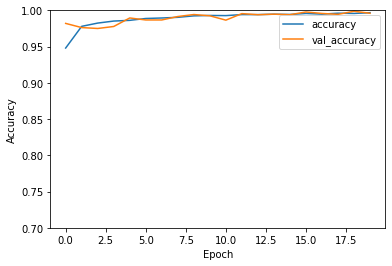

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='best')
plt.show()

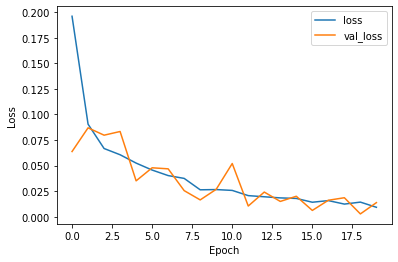

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Evaluate the model

In [34]:
test_loss, test_accuracy = model.evaluate(xval,  ylabel_val, verbose=2)

print('\nTest accuracy = {0:.2f}%'.format(test_accuracy*100.0))

4000/4000 - 0s - loss: 0.0139 - accuracy: 0.9960

Test accuracy = 99.60%


Save the model

In [35]:
# Check if save path exists, if not then create one
save_path = current_path + '/model' 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [36]:
# Save model if the accuracy is greater than 99.875
if round(test_accuracy*100.0,3) > 99.875:
    filename = save_path + '/model' + str(round(test_accuracy*100.0,3))
    model_json = model.to_json()
    with open(filename + '.json', "w") as json_file:
        json_file.write(model_json)

    # Save weights of the model
    model.save_weights(filename+'.h5')